# Setup

In [824]:
import random,copy,math,time,os,sys

from importlib import reload

# numpy/scipy stuff
import numpy as np
import pandas as pd

# plotting stuff
import matplotlib.pyplot as plt

sys.path.insert(1, './../')
import simulations as sims
reload(sims.thermodynamic_model)

# UNCOMMENT IF YOU WANT LATEX IN FIGURES
from matplotlib import rc
FONT_SIZE = 20
rc('font',**{'family':'serif','serif':['CMU Serif']})
rc('axes', titlesize=FONT_SIZE,labelsize=FONT_SIZE)  
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
plt.rc('legend', fontsize=15) 
#mpl.rcParams['font.size'] = 12
rc('text', usetex=True)

%matplotlib inline

# A single TF which cooperates with itself

## Model description

Here we explore the effects of TF-TF interactions on the evolutionary dynamics of a regulatory site. We assume that a there exists a single TF which can bind to either of two regulatory sites for a gene which confers some fitness benefit when expressed. 

In [795]:
M_sites = 2 # number of regulatory binding sites
M_factors = 1 # number of transcription factors
L = 14 # this is the number of nucleotides at each site

# now we make a list of binding energy matrices 
# for each tf (a list of M_factors L x 4 arrays)
E = np.zeros((L,4)) #np.random.normal(0.15,0.1,(L,4)) 
E[:,0] = 1*np.ones(L)
binding_energies = [E] 


# TF-TF interactions (a M_factors x M_factors matrix)
# we will play with this later
interaction_energies = np.array([[0.]]) 

# transcription rates corresponding to each factor at each site (we assume baseline is zero)
rates = np.ones((M_sites,M_factors))  

# TF concentrations 
tf_concentrations = np.array([1.]) # tf concentrations

Now we have all the ingredients to define a model using the ``tf_thermodynamic_model`` class. The main functional of this class is to compute the expression level given the above paramaters and the sequence at the regulatory site. We will also define a fitness function, which maps expression levels fitness, but for simplicity we will assume this the mapping is linear.

In [796]:
# build our model
model = sims.thermodynamic_model.tf_thermodynamic_model(binding_energies,\
                                                        interaction_energies,rates,tf_concentrations,M_sites)

sel= 0.05 # strength of selection on gene expression at site
def fitness_func(model,g): # use expression level as proxy for fitness
    return 0.2+sel*model.expression_level(g)

## Fitness landscape
Now let's take a look at the fitness landscape.

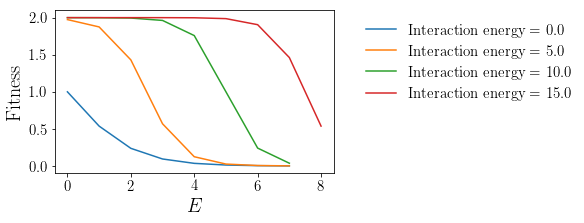

In [797]:
fig,ax = plt.subplots(figsize=(5,3))
for E_coop in [0.,5.,10.,15.]:
    
    model.interaction_energies = np.array([[E_coop]]) 
    g_set = [np.array([np.random.choice(range(4),L)]*M_sites) for k in range(100)]
    f_set = [model.expression_level(g) for g in g_set]
    E_set = [np.sum([binding_energies[0][k,g[0][k]] for k in range(L)]) for g in g_set]

    f_set = [f_set for _,f_set in sorted(zip(E_set,f_set))]
    E_set= sorted(E_set)
    ax.plot(E_set,f_set,'-',label='Interaction energy = {}'.format(E_coop),fillstyle='none')


#ax.set_ylim([0,2.3])
ax.set_xlabel(r'$E$')
ax.set_ylabel('Fitness')
plt.legend(loc='upper right',frameon=False,bbox_to_anchor=(1.9, 1))

## Evolutionary dynamics simulations

In [812]:
ne = 500
tmax = 10
reload(sims.thermodynamic_model)
model = sims.thermodynamic_model.tf_thermodynamic_model(binding_energies,\
                                                        interaction_energies,rates,tf_concentrations,M_sites)
model.interaction_energies = np.array([[10.]])
g0 = np.array([np.zeros(L,dtype=int) for k in range(M_sites)])
trajectory = model.substitution_evolution(tmax,g0,fitness_func,0.2,ne)

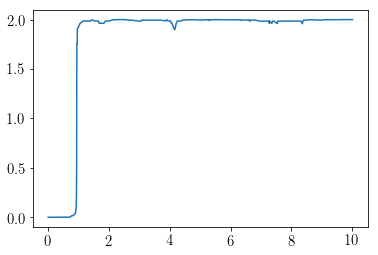

In [813]:
plt.plot(trajectory.time,trajectory.expression_level,'-')
time = np.linspace(trajectory.time[0],trajectory.time[-1],1000)

In [814]:
g_set = [g0]*100
model.interaction_energies = np.array([[0.]])
trajectories,summary = model.substitution_evolution_monte_carlo(tmax,g_set,fitness_func,0.2,ne)
#summary.to_csv('./summary_oneTF_Ec0.csv')

100%|██████████| 100/100 [07:20<00:00,  5.35s/it]


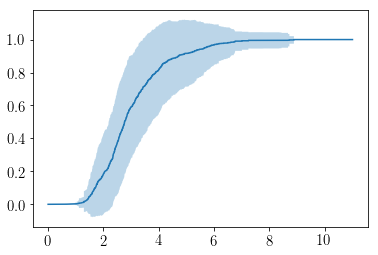

In [815]:
plt.plot(summary.time,summary.expression_level_avg)
plt.fill_between(summary.time,summary.expression_level_avg.values-summary.expression_level_std.values,\
                summary.expression_level_avg.values+summary.expression_level_std.values,alpha=0.3)

In [820]:
g_set = [g0]*100
model.interaction_energies = np.array([[10.]])
trajectories,summary = model.substitution_evolution_monte_carlo(tmax,g_set,fitness_func,0.2,ne)

100%|██████████| 100/100 [17:31<00:00, 12.64s/it]


In [821]:
summary.to_csv('./summary_oneTF_Ec10.csv')

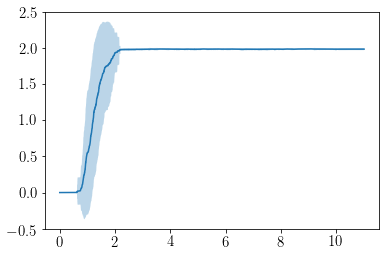

In [822]:
plt.plot(summary.time,summary.expression_level_avg)
plt.fill_between(summary.time,summary.expression_level_avg.values-summary.expression_level_std.values,\
                summary.expression_level_avg.values+summary.expression_level_std.values,alpha=0.3)

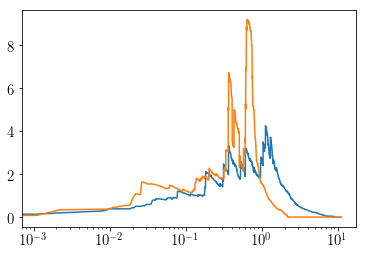

In [836]:
summary_0 = pd.read_csv('./summary_oneTF_Ec0.csv')
summary_10 = pd.read_csv('./summary_oneTF_Ec10.csv')

plt.semilogx(summary_0.time,summary_0.expression_level_std.values/summary_0.expression_level_avg.values)
plt.plot(summary_10.time,summary_10.expression_level_std.values/summary_10.expression_level_avg.values)

# Two TFs which cooperate 

In [752]:
M_sites = 2 
M_factors = 2 


E1 = np.zeros((L,4)) #np.random.normal(0.15,0.1,(L,4)) 
E1[:,1] = 1*np.ones(L)
E2 = np.zeros((L,4)) #np.random.normal(0.15,0.1,(L,4)) 
E2[:,0] = 1*np.ones(L)
binding_energies = [E1,E2] 


# TF-TF interactions (a M_factors x M_factors matrix)
interaction_energies = np.array([[0.,0.5],[0.5,0.]]) 

# transcription rates corresponding to each factor at each site (we assume baseline is zero)
rates = np.ones((M_sites,M_factors))  

# TF concentrations 
tf_concentrations = np.array([1.,1.]) # tf concentrations

In [753]:
ne = 500
tmax = 5
reload(sims.thermodynamic_model)
model = sims.thermodynamic_model.tf_thermodynamic_model(binding_energies,\
                                                        interaction_energies,rates,tf_concentrations,M_sites)
g0 = np.array([np.ones(L,dtype=int) for k in range(M_sites)])
trajectory = model.substitution_evolution(tmax,g0,fitness_func,0.2,ne)

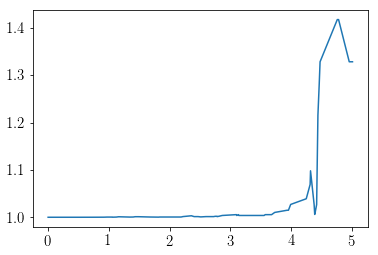

In [754]:
plt.plot(trajectory.time,trajectory.expression_level,'-')